<b>Web Scraping Steam Reviews for Exploratory Data Analysis</b>

This application will scrape the user reviews of a given Steam game. It will return a specified amount of reviews of a specified game. For each review, the application will grab the following information:
- User name
- User ID
- User Country (If publically available to the steam api)
- Date of the review
- Rating of the review
- Text content of the review

This information is then stored into a json file to be used later on for analyzing trends in user reviews.

I have included the interesting examples that I previously gather using the selenium version of my program. There are the JSON files for the following games:
'Antonblast' (app_id = 1887400)
'Marvel Rivals' (app_id = 2767030)
'Overwatch 2' (app_id = 2357570)

With 'Antonblast', I show off an example of using the stored text content of the reviews to create a word cloud using the wordcloud library, I found this to be probably one of the most interesting uses of this sort of data as having speedy access to what it is everyone is actually talking about when reviewing a game can help to give a good idea of the main points of the game, both positive and negative.

I also decided to create a pie chart based off the country of the user that posted the review. Mainly I just wanted to ensure I was using the data that I used the Steam API to gather instead of pure web scraping. Considering many users do not display their country publically, I thought of two ways I could deal with this when presenting the data.
1. I could go ahead and just group countries that were marked as private with the other category to display on the pie chart
2. I could just omit private countries from the data for the pie chart allowing a better look at countries that were actually available

I decided to go with the latter as I felt increasing the size of the 'Other' field would cause the data to be less accurate since it would shrink entries like the USA and it is a safe assumption that many of the private countries will be from the USA.
I decided to represent this data mainly because 'Antonblast' is a game from a small indie studio which most likely has a rather small marketting budget therefore I wanted to see what the global spread of reviews would look like.

Lastly, I decided to compare two games against eachother using a stacked bar graph. These games were 'Marvel Rivals' and 'Overwatch 2'. I went ahead and scraped a large sample of reviews from the both of them (3000 of the most recent reviews from each). I then went ahead and plotted them on the bar graph to directly compare the proportion of negative reviews to positive reviews. The relationship between the games would make this an interesting comparison seeing as at this point in time, 'Marvel Rivals' is being hailed as the better 'Overwatch'. Interestingly, the gap between the two was not as extreme as I had first predicted, though it is still there. 

For most of the earlier lectures in the second term, I was already aware of web scraping techniques due to my prior experience in developing a tool for data gathering for Curve Games, however I did not know much in the way of presenting and vizualising data so the later weeks were quite helpful for me, especially the ones covering pandas databases and the matplot library.

An advanced technique I used was employing the use of Selenium. This was necessary for what I wanted to d as Steam's review page makes use of an infinite scroll set up. This means that in order to load more than ten reviews, I would need to have some form of interaction with the webpage. Since BeautifulSoup and requests wouldn't be enough for this, I decided to use Selenium and ChromeDriver.

The data is retrieved via a combination of webscraping and use of the Steam API. I scrape elements such as the user's display name and id as well as the review date, text content, and rating. I can then use the id to retreive further data about the user through the Steam Api. I use this to access their country without the need to load their profile in ChromeDriver which would slow down the Application immensely. I also grab details aout the review via web scraping as this stuff would not be available through Steam's API.
Please see:
https://steamcommunity.com/robots.txt
https://steamcommunity.com/dev
https://pypi.org/project/python-steam-api/

<div class="alert alert-block alert-info">
Here is the version of the code that uses just BeautifulSoup4 and requests. It is limited in how many reviews it can scrape due to the fact that Steam utilizes infinite scroll for the reviews page, so only the first ten reviews are present upon loading the page.
</div>

In [ ]:
from bs4 import BeautifulSoup
from steam_web_api import Steam
from dotenv import load_dotenv
import os
import json
import re
import requests
from dateutil import parser

def date_to_computer_readable(date):
    try:
        parsed_date = parser.parse(date)
    except:
        return date
    return parsed_date.strftime('%d-%m-%Y')
def generateJSON(data, app_id):
    with open(f'{app_id}.json', 'w') as new_file:
        json.dump(data, new_file, indent=4)
        new_file.close()
def load_steam_api():
    load_dotenv()
    KEY = os.getenv('STEAM_API_KEY')
    return Steam(KEY)
def separate_date_and_review_content(review_box):
    reg_remove = r"Product refunded|Product received for free|Posted: "
    date = review_box.find('div', class_='date_posted').get_text().replace('Posted: ', '')
    review = review_box.find('div', class_='apphub_CardTextContent').get_text().replace(date, '')
    review = re.sub(reg_remove, '', review).strip()
    date = date_to_computer_readable(date)
    return date, review
def create_review_object(user_name, user_ID, country, date, pos_rating, review):
    return {
        "user": user_name,
        "user_ID": user_ID,
        "country": country,
        "date": date,
        "positive rating": pos_rating,
        "review": review
    }
def parse_review_element():
    user = review_box.find('div', class_='apphub_CardContentAuthorName')
    user_ID = user.find('a').get('href').split('/')[-2] 
    date, review = separate_date_and_review_content(review_box)
    pos_rating = True if 'icon_thumbsUp' in review_box.find('div', class_='thumb').find('img').get('src') else False
    try:
        country = steam.users.get_user_details(user_ID)['player']['loccountrycode']
    except:
        country = 'Private' 
    return create_review_object(user.get_text(), user_ID, country, date, pos_rating, review)

steam = load_steam_api()

app_id =int(input('Enter the app id: '))

response = requests.get(f'https://steamcommunity.com/app/{app_id}/reviews/?filterLanguage=all&p=1&browsefilter=mostrecent')

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')

    review_boxes = soup.find_all('div', class_='apphub_Card')
    
    data = []
    for review_box in review_boxes:
        data.append(parse_review_element())

    generateJSON(data, app_id)
else:
    print('Error: Unable to fetch data')



<div class="alert alert-block alert-info">
Below is the version that employs the use of Selenium in order to scrape the steam reviews page while dealing with the 'infinite scroll' aspect. You'll need to ensure you have Chromedriver.exe included in this directory for it to run.
</div>

In [23]:
import re
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from steam_web_api import Steam
from dateutil import parser
from dotenv import load_dotenv
import json
import os


def date_to_computer_readable(date):
    try:
        parsed_date = parser.parse(date)
    except:
        return date
    return parsed_date.strftime('%d-%m-%Y')
def generateJSON(data, app_id):
    with open(f'{app_id}.json', 'w') as new_file:
        json.dump(data, new_file, indent=4)
        new_file.close()
def create_review_object(user_name, user_ID, country, date, pos_rating, review):
    return {
        "user": user_name,
        "user_ID": user_ID,
        "country": country,
        "date": date,
        "positive rating": pos_rating,
        "review": review
    }
def separate_date_and_review_content(review_box):
    reg_remove = r"Product refunded|Product received for free|Posted: "
    date = review_box.find_element(By.CLASS_NAME, 'date_posted').text.replace('Posted: ', '')
    review = review_box.find_element(By.CLASS_NAME, 'apphub_CardTextContent').text.replace(date, '')
    review = re.sub(reg_remove, '', review).strip()
    date = date_to_computer_readable(date)
    return date, review
def start_chromedriver():
    options = Options()
    options.add_argument("--headless")
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument('--disable-extensions')
    options.add_argument('--disable-popup-blocking')
    options.add_argument('--profile-directory=Default')
    options.add_argument('--disable-notifications')
    options.add_argument('--disable-logging')
    options.add_argument('--disable-plugins-discovery')
    options.add_argument('--incognito')  
    options.add_argument('--disable-blink-features=AutomationControlled')  
    driver = webdriver.Chrome(options=options)
    driver.get(f'https://steamcommunity.com/app/{app_id}/reviews/?filterLanguage=all&p=1&browsefilter=mostrecent')
    return driver
def get_infinite_scroll_reviews():
    review_boxes = []
    while True:
        try:
            review_boxes = driver.find_elements(By.CLASS_NAME, 'apphub_Card')
            if len(review_boxes) > target_review_count:
                break
            if driver.find_element(By.CLASS_NAME, 'apphub_NoMoreContentText2').is_displayed():
                break
            driver.execute_script("javascript:CheckForMoreContent()")
        except:
            break
    print(str(len(review_boxes)) + " reviews found!")
    return review_boxes
def parse_review_element():
    user = review_box.find_element(By.CLASS_NAME, 'apphub_CardContentAuthorName').text
    user_ID = review_box.find_element(By.TAG_NAME, 'a').get_dom_attribute('href').split('/')[-2]
    date, review = separate_date_and_review_content(review_box)
    pos_rating = True if 'icon_thumbsUp' in review_box.find_element(By.CLASS_NAME, 'thumb').find_element(By.TAG_NAME, 'img').get_attribute('src') else False
    try:
        country = steam.users.get_user_details(user_ID)['player']['loccountrycode']
    except:
        country = 'Private'
    return create_review_object(user, user_ID, country, date, pos_rating, review)
def load_steam_api():
    load_dotenv()
    KEY = os.getenv('STEAM_API_KEY')
    return Steam(KEY)

steam = load_steam_api()

app_id =int(input('Enter the app id: '))
target_review_count = int(input('Enter the target number of reviews to scrape: '))

driver = start_chromedriver()
driver.get(f'https://steamcommunity.com/app/{app_id}/reviews/?filterLanguage=all&p=1&browsefilter=mostrecent')

review_boxes = get_infinite_scroll_reviews()

data = []
for review_box in review_boxes:
    data.append(parse_review_element())

driver.quit()

generateJSON(data, app_id)

1254 reviews found!


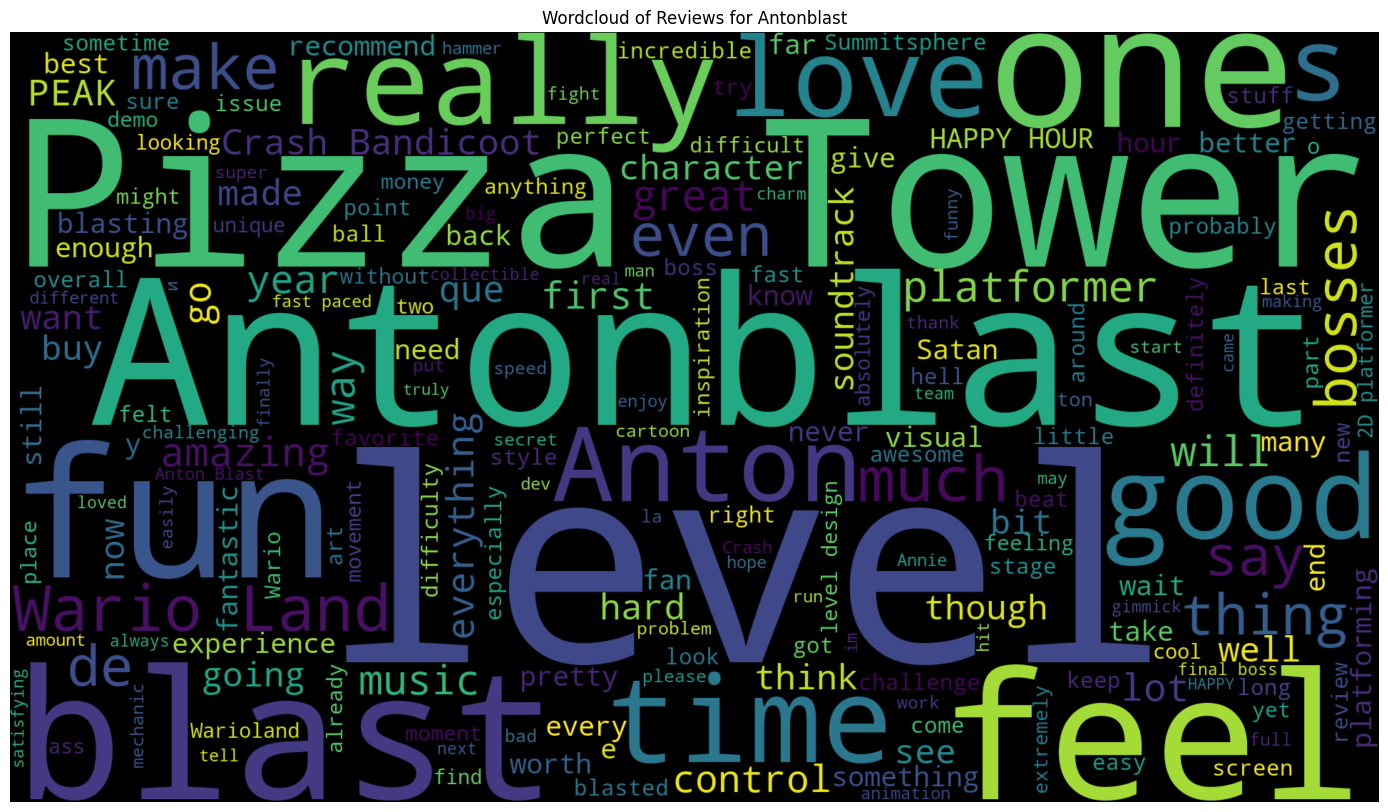

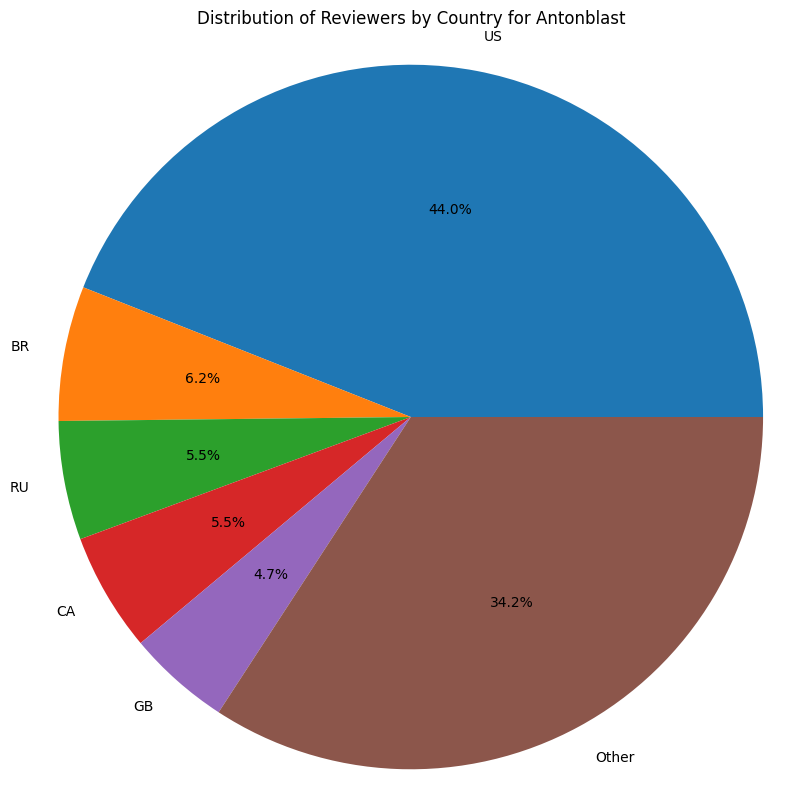

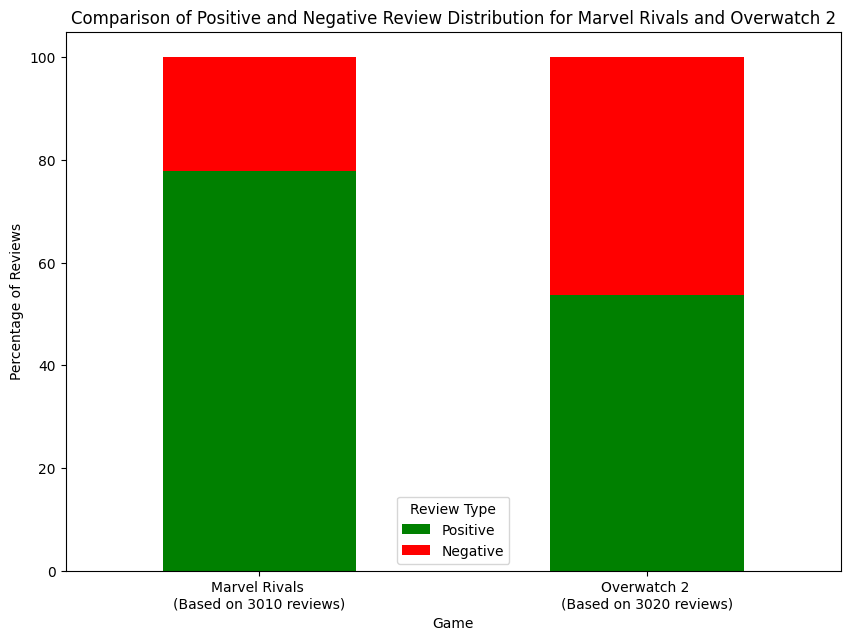

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# This will generate a wordcloud for the reviews of 'Antonblast' (app_id = 1887400)
# Load the data into a pandas dataframe
df = pd.read_json("1887400.json")

# Join all the reviews into a single string.
word_string = ' '.join(df['review']).replace('game', '')

# Run through a regex made up for frequently used words that don't add value to the wordcloud.
pointless_words = r'\b(game|gameplay|played|play|playing|player|games)\b' 
word_string = re.sub(pointless_words, '', word_string, flags=re.IGNORECASE)

# Generate the wordcloud and display it.
wordcloud = WordCloud(width=1920, height=1080).generate(word_string)
plt.imshow(wordcloud, interpolation='bilinear')
plt.gcf().set_size_inches(20, 10)
plt.axis('off')
plt.title('Wordcloud of Reviews for Antonblast')
plt.show()

# This will generate a pie chart of the countries of the reviewers of
# 'Antonblast' (app_id = 1887400) (with smaller values grouped as 'Other' and 
# any private profiles excluded)
df = pd.read_json("1887400.json")
df = df[df['country'] != 'Private']
countries = df['country'].value_counts()
countries = countries[countries > len(df)*0.03]
countries['Other'] = len(df) - countries.sum()
countries.plot.pie(autopct='%1.1f%%')
plt.title('Distribution of Reviewers by Country for Antonblast')
plt.ylabel('')
plt.gcf().set_size_inches(10, 10)
plt.axis('equal')
plt.show()

# This will generate a stacked bar graph comparing the number of positive reviews between 'Marvel Rivals' 
# (app_id = 2767030) and 'Overwatch 2' (app_id = 2357570)
# Create a stacked bar graph comparing the number of positive and negative reviews between 'Marvel Rivals' and 'Overwatch 2'

df_marvel = pd.read_json("2767030.json")
df_overwatch = pd.read_json("2357570.json")

pos_marvel = len(df_marvel[df_marvel['positive rating']])
neg_marvel = len(df_marvel) - pos_marvel

pos_marvel_pct = pos_marvel / len(df_marvel) * 100
neg_marvel_pct = 100 - pos_marvel_pct

pos_overwatch = len(df_overwatch[df_overwatch['positive rating']])
neg_overwatch = len(df_overwatch) - pos_overwatch

pos_overwatch_pct = pos_overwatch / len(df_overwatch) * 100
neg_overwatch_pct = 100 - pos_overwatch_pct

df_pos_neg = pd.DataFrame({
    'Marvel Rivals \n(Based on ' + str(len(df_marvel)) + ' reviews)': [pos_marvel_pct, neg_marvel_pct],
    'Overwatch 2 \n(Based on ' + str(len(df_overwatch)) + ' reviews)': [pos_overwatch_pct, neg_overwatch_pct]
}, index=['Positive', 'Negative'])

df_pos_neg.T.plot(kind='bar', stacked=True, color=['green', 'red'], rot=0)
plt.title('Comparison of Positive and Negative Review Distribution for Marvel Rivals and Overwatch 2')
plt.xlabel('Game')
plt.ylabel('Percentage of Reviews')
plt.legend(title='Review Type')
plt.gcf().set_size_inches(10, 7)
plt.show()





3. Reflect on project management (approx 250 words) 
    - Timeliness: Reflect on how consistently you made an effort meet deadlines
    - Organization: Reflect on how managed the code-base as the project size increased

In terms of timeliness, I believe I stayed fairly on track due to the structure of the course going through the content at a very steady and structured pace. Each lab I would finish essentially always where I was meant to be and ready to continue on with the project.


4. Process reflection (approx 200 words) - Discuss the week by week iterative development of your chatbot.
    - Describe each week of chatbot devleopment.
    - What was the feedback you received? How did you work on the feedback to improve EDA? What new features did you add? 

-----------------------------------------------------

Reflection goes here

-----------------------------------------------------
